<a href="https://colab.research.google.com/github/mafaves/AI-projects/blob/main/image_dataset/Chest_X-Ray_Images_Pneumonia/pytorch_and_torchbearer_cnn_chest_x_ray_pneumonia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://github.com/patrickloeber/pytorchTutorial/blob/master/14_cnn.py

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Feb  5 08:46:48 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-SXM2-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0              23W / 300W |      0MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [1]:
# Imports
import torch
import torch.nn as nn  # All neural network modules, nn.Linear, nn.Conv2d, BatchNorm, Loss functions
import torch.optim as optim  # For all Optimization algorithms, SGD, Adam, etc.
import torchvision.transforms as transforms
from torchvision.transforms import  v2 # Transformations we can perform on our dataset
import torchvision
import os
import pandas as pd
from PIL import Image
from torch.utils.data import (
    Dataset,
    DataLoader,
    random_split
)  # Gives easier dataset managment and creates mini batches
from torchvision import datasets, transforms

import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from glob import glob
import zipfile
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#path to the kaggle.json directory
path_API_autentification_token= '/content/drive/MyDrive/Colab_Notebooks/master/Chest_X_Ray_Images_Pneumonia'

In [4]:
# Coping the kaggle API to the Google Colab
os.environ['KAGGLE_CONFIG_DIR'] = path_API_autentification_token

# Downloading the data
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

# Unzziping the data and storing into /tmp
zip_ref = zipfile.ZipFile('chest-xray-pneumonia.zip', 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

100% 2.29G/2.29G [00:58<00:00, 44.9MB/s]
100% 2.29G/2.29G [00:58<00:00, 41.9MB/s]


## DATA PREPARATION

The downloaded data contain 3 main folders: 'test', 'val' and 'test'. Inside each one, there are two subcategories: 'NORMAL' and 'PNEUMONIA'.

 In this case, I prefer to only have two: 'NORMAL' and 'PNEUMONIA' (I prefer it in order to manage all images with tf)

In [5]:
import os
import shutil

def move_files(src_path, dest_path):
    if not os.path.exists(dest_path):
        os.makedirs(dest_path)

    for filename in os.listdir(src_path):
        file_path = os.path.join(src_path, filename)
        shutil.move(file_path, os.path.join(dest_path, filename))

extracted_dir = '/tmp/chest_xray'
main_folders = ['train', 'val', 'test']
output_folders = ['NORMAL', 'PNEUMONIA']

# Move files from subfolders to main folders
for main_folder in main_folders:
    for output_folder in output_folders:
        move_files(os.path.join(extracted_dir, main_folder, output_folder), os.path.join(extracted_dir, output_folder))

# Print the number of files in 'NORMAL' and 'PNEUMONIA' folders
for folder_name in ['NORMAL', 'PNEUMONIA']:
    folder_path = os.path.join(extracted_dir, folder_name)
    file_count = len(os.listdir(folder_path))
    print(f"Number of files in '{folder_name}' folder: {file_count}")

# Move 'NORMAL' and 'PNEUMONIA' folders into the 'images' folder
images_dir = os.path.join(extracted_dir, 'images')
move_files(os.path.join(extracted_dir, 'NORMAL'), os.path.join(images_dir, 'NORMAL'))
move_files(os.path.join(extracted_dir, 'PNEUMONIA'), os.path.join(images_dir, 'PNEUMONIA'))

print("Folders moved successfully.")


Number of files in 'NORMAL' folder: 1583
Number of files in 'PNEUMONIA' folder: 4273
Folders moved successfully.


In [6]:
# Define the path to the extracted directory
extracted_dir = '/tmp/chest_xray/images'

# List the contents of the directory
contents = os.listdir(extracted_dir)

# Print the contents
print(contents)

['NORMAL', 'PNEUMONIA']


# BUILDING THE MODEL WITH PYTORCH

In [7]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

#### HYPERPARAMETERS

In [8]:
# Hyperparameters
in_channel = 3
num_classes = 2
learning_rate = 3e-4
batch_size = 32
num_epochs = 5

#### DATA AUGMENTATION

In [9]:
# Define data transformations
transform = v2.Compose([
    v2.Resize((224, 224)),  # Resize images to a common size
    v2.RandomHorizontalFlip(p=0.2),
    v2.RandomVerticalFlip(p=0.3),
    v2.RandomRotation(degrees=[-15,15]),
    v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)]),
    v2.Normalize(mean=[0.4661, 0.4661, 0.4661], std=[0.2487, 0.2487, 0.2487])
])

##DATA UPLOAD

In [10]:
# Specify the path to your dataset
data_path = '/tmp/chest_xray/images'

In [11]:
# Create a dataset from the folders and apply transformations
dataset = datasets.ImageFolder(root=data_path, transform=transform) #Return type: List[Tuple[str, int]]

# Create a DataLoader to iterate through the dataset
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

num_classes = len(dataset.classes)
# Count the number of images in each class
class_counts = {class_idx: 0 for class_idx in range(num_classes)}

for _, labels in data_loader.dataset.samples:
    class_counts[labels] += 1

# Print the number of images in each class
for class_idx, count in class_counts.items():
    print(f"Class {class_idx}: {count} images")

Class 0: 1583 images
Class 1: 4273 images


### Checking image pixel mean and std

In [30]:
# Assuming you have a DataLoader named 'data_loader'
mean_list, std_list = [], []

for images, _ in data_loader:
    mean_list.append(np.mean(images.numpy(), axis=(0, 2, 3)))
    std_list.append(np.std(images.numpy(), axis=(0, 2, 3)))

mean = np.mean(mean_list, axis=0)
std = np.mean(std_list, axis=0)

print("Calculated mean:", mean)
print("Calculated std:", std)

Calculated mean: [0.00023584 0.00023584 0.00023584]
Calculated std: [1.0000143 1.0000143 1.0000143]


## SPLITING DATA

In [12]:
# Define the sizes for train, validation, and test sets
total_size = len(dataset)
train_size = int(0.8 * total_size)  # 80% for training
val_size = int(0.1 * total_size)   # 10% for validation
test_size = total_size - train_size - val_size  # remaining for testing

In [13]:
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

In [14]:
len(train_dataset)

4684

To calculate the weights for handling class imbalance, we can use the inverse of the class frequencies.

###  HANDLING IMBALANCED DATA

The split should be agnostic to the way you sample/process your training data. Only after you have a training split of the data you can apply WeightedRandomSampler to it.

[link](https://pytorch.org/docs/stable/data.html#torch.utils.data.random_split)

In [15]:
from torch.utils.data.sampler import WeightedRandomSampler

In [30]:
class_weights = np.array([1.0 / class_counts[class_idx] for class_idx in range(len(dataset.classes))])
class_weights /= sum(class_weights)
class_weights

array([0.72967896, 0.27032104])

In [16]:
def calculate_sample_weights_and_load(dataset, class_weigths):

  num_samples = len(dataset)
  print(f"The {dataset} has {num_samples} images")

  sample_weights = [0] * num_samples

  # We need to put the weights to each sample
  for idx, (data, label) in enumerate(dataset):
    class_weight = class_weights[label]
    sample_weights[idx] = class_weight

  #convert to correct format
  sample_weights = torch.from_numpy(np.array(sample_weights))
  sample_weights = sample_weights.double()

  #Create the sampler

  sampler = WeightedRandomSampler(sample_weights, num_samples=num_samples, replacement=True)

  #load
  loader = DataLoader(dataset, batch_size=batch_size, sampler = sampler)

  return loader


In [31]:
train_loader = calculate_sample_weights_and_load(train_dataset,class_weights)
val_loader = calculate_sample_weights_and_load(val_dataset, class_weights)
test_loader = calculate_sample_weights_and_load(test_dataset, class_weights)

The <torch.utils.data.dataset.Subset object at 0x7fa9a3cb77f0> has 4684 images
The <torch.utils.data.dataset.Subset object at 0x7fa9a3cb7490> has 585 images
The <torch.utils.data.dataset.Subset object at 0x7fa9a3cb78b0> has 587 images


In [32]:
len(val_loader)*32

608

In [33]:
def count_label_occurrences(data_loader, label_values):
    # Initialize counts for each label
    label_counts = {label: 0 for label in label_values}

    # Iterate through the data loader
    for _, labels in data_loader:
        # Count occurrences of each label
        for label in labels:
            label_counts[label.item()] += 1

    # Print the count of each label
    print(f"The count for each label in {data_loader} is:")
    for label, count in label_counts.items():
        print(f"Label {label}: {count} occurrences")



In [34]:
# Example usage with your train_loader and label_values
# Assuming label_values is a list containing the unique label values in your dataset
label_values = [0, 1]
count_label_occurrences(train_loader, label_values)

The count for each label in <torch.utils.data.dataloader.DataLoader object at 0x7fa9a550f670> is:
Label 0: 2482 occurrences
Label 1: 2202 occurrences


In [35]:
# Checking we have both classes in each batch
for images, labels in train_loader:
    # Print labels or analyze them to check the distribution
    print(labels)
    break

tensor([1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 1, 0, 1, 0])


In [ ]:
# Printing some information about types
for i, (images, labels) in enumerate(train_loader):
    print(f"Batch {i + 1}:")
    print(f"Images shape: {images.shape}")
    print(f"Labels shape: {labels.shape}")
    break  # Stop after the first batch for brevity

Batch 1:
Images shape: torch.Size([32, 3, 224, 224])
Labels shape: torch.Size([32])


In [ ]:
def get_class_proportions(loader, classes):
    class_counts = {class_idx: 0 for class_idx in range(len(classes))}
    total_images = 0

    for _, labels in loader:
        for label in labels:
            class_counts[label.item()] += 1
            total_images += 1

    class_proportions = {class_idx: count / total_images for class_idx, count in class_counts.items()}

    return class_counts, class_proportions, total_images

Image shape: (3, 224, 224)
Number of channels: 3
Min value: -2.964735e-08
Max value: 0.94117653


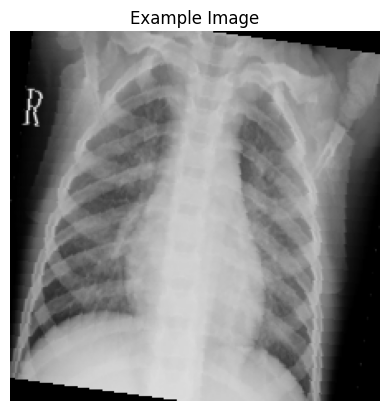

In [ ]:
# Load a batch of images
for images, labels in train_loader:
    example_image = images[0]  # Take the first image from the batch
    break

inverse_normalize = v2.Normalize(mean=[-0.4661/0.2487, -0.4661/0.2487, -0.4661/0.2487], std=[1/0.2487, 1/0.2487, 1/0.2487])

# Apply inverse normalization
example_image = inverse_normalize(example_image)
# Clip pixel values to the valid range [0, 1]
#example_image= np.clip(example_image, 0, 1)

# Convert the PyTorch tensor to a NumPy array
example_image_array = example_image.numpy()

# Print the shape of the NumPy array
print("Image shape:", example_image_array.shape)

# Print the number of channels
num_channels = example_image_array.shape[0]
print("Number of channels:", num_channels)

print("Min value:", example_image_array.min())
print("Max value:", example_image_array.max())

# Visualize the image
plt.imshow(np.transpose(example_image_array, (1, 2, 0)))  # Transpose to (H, W, C) for proper visualization*
plt.title(f"Example Image")
plt.axis('off')
plt.show()

*In PyTorch, the typical order of dimensions for an image tensor is (C, H, W), where: C is the number of channels,
H is the height of the image, and
W is the width of the image.

However, matplotlib expects the channel dimension to be the last one, in the order (H, W, C). So, the np.transpose function is used to swap the dimensions accordingly. The expression np.transpose(example_image_array, (1, 2, 0)) indicates that the new order of dimensions should be (1, 2, 0),

In [20]:
class cnn_x_chest(nn.Module):
    def __init__(self, num_classes=1):
        super(cnn_x_chest, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 128, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv4 = nn.Conv2d(32, 16, kernel_size=3, stride=1, padding=1)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully connected layers
        self.fc1 = nn.Linear(16 * 14 * 14, 512)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(512, num_classes)
    # defines the forward pass of the neural network
    def forward(self, x):
        x = self.pool1(nn.functional.relu(self.conv1(x))) # -> n, 128, H/2, W/2
        x = self.pool2(nn.functional.relu(self.conv2(x))) # -> n, 64, H/4, W/4
        x = self.pool3(nn.functional.relu(self.conv3(x))) # -> n, 32, H/8, W/8
        x = self.pool4(nn.functional.relu(self.conv4(x))) # -> n, 32, H/16, W/16
        x = x.view(-1, 16 * 14 * 14) # -> n, 16 * 14 * 14
        x = self.relu1(self.fc1(x)) # -> n, 512
        x = self.fc2(x) # -> n, num_classes
        return torch.sigmoid(x)

In [18]:
from torchsummary import summary

In [21]:
model = cnn_x_chest().to(device)

In [49]:
summary(model, input_size= (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [-1, 128, 224, 224]           3,584
         MaxPool2d-2        [-1, 128, 112, 112]               0
            Conv2d-3         [-1, 64, 112, 112]          73,792
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 32, 56, 56]          18,464
         MaxPool2d-6           [-1, 32, 28, 28]               0
            Conv2d-7           [-1, 16, 28, 28]           4,624
         MaxPool2d-8           [-1, 16, 14, 14]               0
            Linear-9                  [-1, 512]       1,606,144
             ReLU-10                  [-1, 512]               0
           Linear-11                    [-1, 1]             513
Total params: 1,707,121
Trainable params: 1,707,121
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forw

In [50]:
# Criterion (Loss function)
criterion = nn.BCELoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

https://stackoverflow.com/questions/53628622/loss-function-its-inputs-for-binary-classification-pytorch

In [25]:
from tqdm.notebook import trange, tqdm

### TRAINING

In [52]:
def train_model(model, train_loader, test_loader, optimizer, criterion, num_epochs, device='cuda'):
  liveloss = PlotLosses()
  loss_list = []
  iteration_list = []
  accuracy_list = []
  count = 0

  for epoch in tqdm(range(num_epochs)):
      total_loss = 0.0

      for i, (images, labels) in enumerate(train_loader):
          images, labels = images.to(device), labels.to(device)
          labels = labels.float()


          optimizer.zero_grad()
          outputs = model(images)
          loss = criterion(outputs, labels.unsqueeze(1))
          loss.backward()
          optimizer.step()

          count += 1

          if count % 10 == 0:
            accuracy = test_during_training(test_loader)

            loss_list.append(loss.item())
            iteration_list.append(count)
            accuracy_list.append(accuracy)

          if count % 250 == 0:
              print(f'Iteration: {count}  Loss: {loss.item():.3f}  Accuracy: {accuracy:.3f}%')

  return loss_list, iteration_list, accuracy_list

In [54]:
def test_during_training(test_loader):
  correct = 0
  total = 0

  for images, target in test_loader:
    test, target = images.to(device), target.to(device)
    target = target.float()
    target = target.unsqueeze(1)

    outputs = model(test)
    predicted = outputs.round()

    total += len(target)
    correct += (predicted == target).sum()

    accuracy = 100 * correct / float(total)
  return accuracy

In [56]:
loss_list, iteration_list, accuracy_list = train_model(model, train_loader, test_loader, optimizer, criterion, num_epochs=3, device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Iteration: 250  Loss: 0.101  Accuracy: 93.697%


In [62]:
# Assuming output is a list of PyTorch tensors
#output_loss = [tensor.item() for tensor in loss_list]
output_acc = [tensor.item() for tensor in accuracy_list]

# Convert the list to a NumPy array
#loss_list_np = np.array(output_loss)
accuracy_list_np = np.array(output_acc)


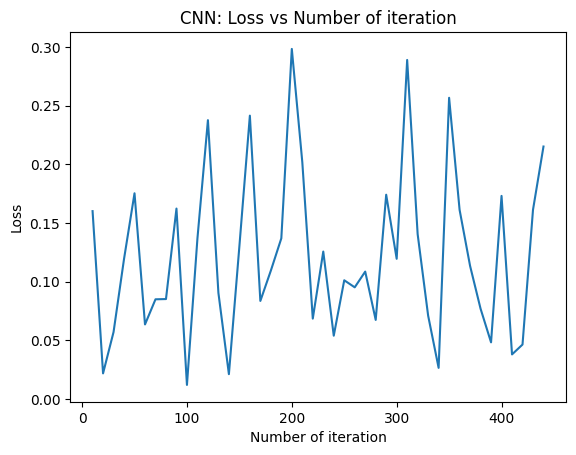

In [58]:
# visualization loss
plt.plot(iteration_list, loss_list)
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("CNN: Loss vs Number of iteration")
plt.show()


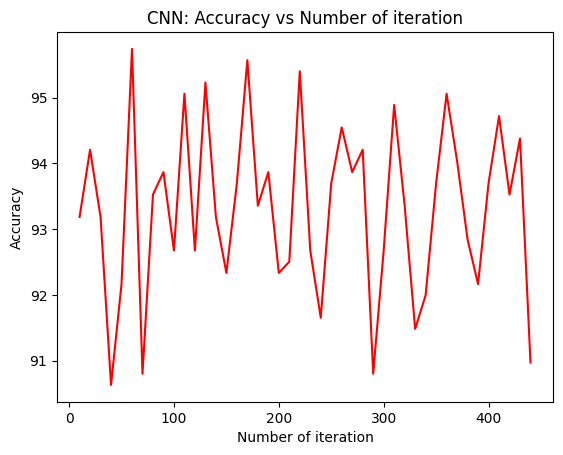

In [63]:
# visualization accuracy
plt.plot(iteration_list,accuracy_list_np,color = "red")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("CNN: Accuracy vs Number of iteration")
plt.show()

### EVALUATING

In [ ]:
import torch
from sklearn.metrics import accuracy_score, confusion_matrix

def test(model,test_loader,device):

    # Move the model to the specified device
    model.to(device)
    # Set the model to evaluation mode
    model.eval()

    y_true = []
    y_pred = []

    # Set the requires_grad flag to false as we are in the test mode
    with torch.no_grad():
        for data, target in test_loader:
            # Moving the tensors to the configured device
            data, target = data.to(device), target.to(device)
            # Convert target to float
            target = target.float()

            # Forward pass
            output = model(data.float())

            # Predictions (using torch.Tensor.round() instead of np.round())
            pred = output.round()

            # Extend lists with true and predicted values
            y_true.extend(target.cpu().numpy().tolist())
            y_pred.extend(pred.cpu().numpy().reshape(-1).tolist())

    # Calculate accuracy using scikit-learn's accuracy_score
    accuracy = accuracy_score(y_true, y_pred)
    print("Accuracy on the test set:", accuracy)

    # Calculate confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:")
    print(conf_matrix)


In [ ]:
# Testing after each epoch
test(model, val_loader, device)

Accuracy on the test set: 0.9572649572649573
Confusion Matrix:
[[256  15]
 [ 10 304]]


# MODEL CREATED WITH TORCHBEARER


https://torchbearer.readthedocs.io/en/latest/code/main.html

https://github.com/stared/livelossplot/blob/master/examples/torchbearer.ipynb

In [68]:
!pip install torchbearer -q
!pip install livelossplot -q
pip install tensorboardX -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 4.5 MB/s eta 0:00:00


In [13]:
#pip install --upgrade torch torchvision

In [70]:
from livelossplot import PlotLossesKeras

In [71]:
import torchbearer
from torchbearer import Trial
from torchbearer.callbacks import LiveLossPlot
from torchbearer.cv_utils import DatasetValidationSplitter
import torchbearer.callbacks as callbacks
from torchbearer.callbacks import imaging
from torchsummary import summary

In [87]:
import tensorboardX

In [88]:
from torchbearer.callbacks import TensorBoard

In [72]:
print(torchbearer.__version__)

0.5.5


In [69]:
# Hyperparameters
in_channel = 3
num_classes = 2
learning_rate = 3e-4
batch_size = 32
num_epochs = 5
height = 224
width = 224

In [73]:
inv_normalize = v2.Normalize(mean=[-0.4661/0.2487, -0.4661/0.2487, -0.4661/0.2487], std=[1/0.2487, 1/0.2487, 1/0.2487])

make_grid = imaging.MakeGrid(torchbearer.INPUT, num_images=64, nrow=8, transform=inv_normalize)
make_grid = make_grid.on_test().to_pyplot().to_file('sample.png')

In [75]:
class cnn_x_chest_torchbearer(nn.Module):
    def __init__(self, num_classes=2):
        super(cnn_x_chest_torchbearer, self).__init__()
        self.convs = nn.Sequential(
            nn.Conv2d(3, 128, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 16, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        # Calculate the size of the linear layer dynamically
        self.fc_size = self._calculate_fc_size()

        self.classifier = nn.Linear(self.fc_size, num_classes)

    def _calculate_fc_size(self):
        # Dummy input to get the output shape after convolutions
        dummy_input = torch.randn(1, 3, 224, 224)
        conv_output_shape = self._get_conv_output_shape(dummy_input)

        # Calculate the size of the linear layer
        fc_size = conv_output_shape[0] * conv_output_shape[1] * conv_output_shape[2]
        print(fc_size)
        return fc_size

    def _get_conv_output_shape(self, x):
        x = self.convs(x)
        return x.shape[-3:]

    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self.fc_size)

        return self.classifier(x)

In [83]:
model_torchbearer = cnn_x_chest_torchbearer().to(device)

In [84]:
summary(model_torchbearer, input_size=(in_channel, height, width))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [-1, 128, 224, 224]           3,584
         MaxPool2d-2        [-1, 128, 112, 112]               0
            Conv2d-3         [-1, 64, 112, 112]          73,792
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 32, 56, 56]          18,464
         MaxPool2d-6           [-1, 32, 28, 28]               0
            Conv2d-7           [-1, 16, 28, 28]           4,624
         MaxPool2d-8           [-1, 16, 14, 14]               0
            Linear-9                    [-1, 2]           6,274
Total params: 106,738
Trainable params: 106,738
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 69.98
Params size (MB): 0.41
Estimated Total Size (MB): 70.96
-----------------------------------------

In [89]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model_torchbearer.parameters()), lr=0.001)
loss = nn.CrossEntropyLoss()

In [85]:
# Create a dataset from the folders and apply transformations
dataset = datasets.ImageFolder(root=data_path, transform=transform) #Return type: List[Tuple[str, int]]

splitter = DatasetValidationSplitter(len(dataset), 0.1)

trainset = splitter.get_train_dataset(dataset)
valset = splitter.get_val_dataset(dataset)


traingen = DataLoader(trainset, pin_memory=False, batch_size=batch_size, shuffle=True, num_workers=0)
valgen = DataLoader(valset, pin_memory=False, batch_size=batch_size, shuffle=True, num_workers=0)




In [91]:
callbacks = [TensorBoard(write_graph=True, write_batch_metrics=False, write_epoch_metrics=False)]
callbacks.append(make_grid)

trial = Trial(model_torchbearer, optimizer, loss, metrics=['acc', 'loss'], callbacks=callbacks).to(device)
trial.with_generators(train_generator=traingen, val_generator=valgen)
history = trial.run(epochs=5, verbose=1)

  0%|          | 0/5 [00:00<?, ?it/s]

In [115]:
train_acc = []
train_loss = []
val_acc = []
val_loss = []
epochs = []
epoch = 1
for entry in history:
    epochs.append(epoch)
    train_acc.append(entry['acc'])
    train_loss.append(entry['loss'])
    val_acc.append(entry['val_acc'])
    val_loss.append(entry['val_loss'])
    epoch += 1

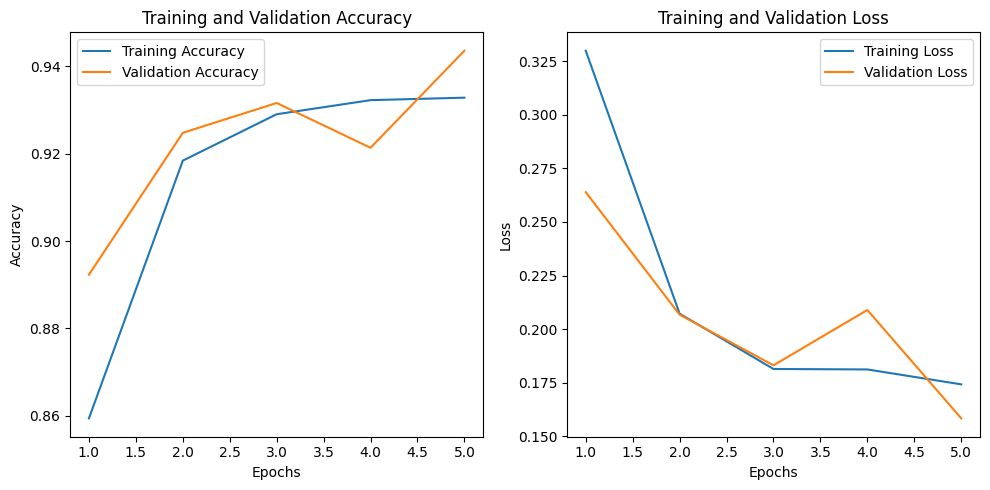

In [116]:
# Plotting
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()